In [1]:
import time
import math
import os
import torch.nn as nn

import torch.onnx
import torch
from torch.autograd import Variable
import torch.optim as optim

import model as rnn_model
import data

In [8]:
args_seed = 1234
args_temperature = 1.
args_data = '../data/recipes/text/'
args_model = 'LSTM'
args_emsize = 650
args_nhid = 650
args_nlayers = 2
args_clip = 0.25
args_epochs = 120
args_adam_lr = 0.0001
args_batch_size = 20
args_bptt = 300
args_dropout = 0.5
args_log_interval = 100
args_save = args_data + 'model_300_650_0.5.pt'
args_save_state = args_data + 'model_state_300_650_0.5.pt'
args_tied = True

In [9]:
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using device: {device}')

using device: cuda


In [10]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args_data)

In [11]:
len(corpus.dictionary)

9023

In [12]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args_batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [13]:
###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)

criterion = nn.CrossEntropyLoss()

In [14]:
###############################################################################
# Use Adam optimizer
###############################################################################

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=args_adam_lr)

In [15]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [16]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args_bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args_bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)

train_losses = []
def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args_batch_size)
    record_loss = 0
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args_bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()   # zero the gradient buffers
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args_clip)
        optimizer.step()    # Does the update
        total_loss += loss.item()
        record_loss += loss.item()

        if batch % args_log_interval == 0 and batch > 0:
            cur_loss = total_loss / args_log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args_bptt, 
                elapsed * 1000 / args_log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    train_losses.append(record_loss/train_data.size(0))


In [17]:
# Loop over epochs.
best_val_loss = None

valid_losses = []

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(0, args_epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        valid_losses.append(val_loss)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            ## Save State Dictionary
            with open(args_save_state, 'wb') as f:
                torch.save(model.state_dict(), f)
            best_val_loss = val_loss

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 19.44s | valid loss  6.02 | valid ppl   412.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 17.51s | valid loss  5.81 | valid ppl   335.10
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 17.49s | valid loss  5.66 | valid ppl   287.65
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 17.44s | valid loss  5.55 | valid ppl   256.62
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 17.40s | valid loss  3.38 | valid ppl    29.41
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  34 | time: 17.42s | valid loss  3.36 | valid ppl    28.76
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  35 | time: 17.39s | valid loss  3.33 | valid ppl    27.94
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 17.42s | valid loss  3.31 | valid ppl    27.27
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  66 | time: 17.42s | valid loss  2.92 | valid ppl    18.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  67 | time: 17.44s | valid loss  2.91 | valid ppl    18.40
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  68 | time: 17.43s | valid loss  2.91 | valid ppl    18.30
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  69 | time: 17.43s | valid loss  2.90 | valid ppl    18.17
--------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  99 | time: 17.38s | valid loss  2.78 | valid ppl    16.07
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 100 | time: 17.37s | valid loss  2.78 | valid ppl    16.07
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 101 | time: 17.40s | valid loss  2.77 | valid ppl    16.00
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch 102 | time: 17.40s | valid loss  2.77 | valid ppl    15.94
--------------------------------------------------------------------------

In [18]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


| End of training | test loss  2.69 | test ppl    14.70


# Try to generate with this model now

In [19]:
args_checkpoint = args_save #'./model.pt'
args_state_dict = args_save_state # './model_state.pt'
args_outf = 'gen_recipes_300_650_0.5.txt'
args_words = 2000
args_seed = 1234
args_temperature = 1.0
args_log_interval = 100

In [9]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [10]:
if args_temperature < 1e-3:
    print("args_temperature has to be greater or equal 1e-3")


In [11]:
corpus = data.Corpus(args_data)
ntokens = len(corpus.dictionary)

In [14]:
with open(args_checkpoint, 'rb') as f:
    model = torch.load(f).to(device)
# model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)
# with open(args_state_dict, 'rb') as f:
#     state_dict = torch.load(f)
#     model.load_state_dict(state_dict)

In [20]:
hidden = model.init_hidden(1)
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

In [21]:
model.eval()

RNNModel(
  (drop): Dropout(p=0.5)
  (encoder): Embedding(9023, 650)
  (rnn): LSTM(650, 650, num_layers=2, dropout=0.5)
  (decoder): Linear(in_features=650, out_features=9023, bias=True)
)

In [22]:
with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/2000 words
| Generated 100/2000 words
| Generated 200/2000 words
| Generated 300/2000 words
| Generated 400/2000 words
| Generated 500/2000 words
| Generated 600/2000 words
| Generated 700/2000 words
| Generated 800/2000 words
| Generated 900/2000 words
| Generated 1000/2000 words
| Generated 1100/2000 words
| Generated 1200/2000 words
| Generated 1300/2000 words
| Generated 1400/2000 words
| Generated 1500/2000 words
| Generated 1600/2000 words
| Generated 1700/2000 words
| Generated 1800/2000 words
| Generated 1900/2000 words


In [23]:
with open(args_outf, 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line)

orchestra spoonbread once shortens a batch of his quinoa faithfully the dough is t be baked . yield : 2

large loaf , 8 dinner rolls . <eos> <eos> <eos> egg <eos> <eos> likewise bread <eos> <eos> this red pear

cornbread is marshmallows with fresh and a perfect ( much any gluten-free 255g ) ) , or try to make

a sandwich ( making great grilled cheddar cheese ) instead . start the remaining cinnamon flour is delicious exceptional a

dense , moist filling . <eos> <eos> olive oil <eos> <eos> 170 g king arthur white whole wheat flour <eos>

1 tablespoon sugar <eos> 25 g sugar <eos> 1 1/4 teaspoons instant yeast <eos> 14 g rolled flour <eos> 1

1/2 teaspoons salt <eos> 76 g cream <eos> 57 g lukewarm water <eos> 85 g softened butter <eos> 241 g

king arthur unbleached all-purpose flour <eos> 35 g baker 's special dry milk or nonfat dry milk <eos> 43 g

potato flour or dry flour <eos> <eos> place the ingredients in the pan of bread machine , until the dough

cycle and refreshed , and get thro

In [19]:
model.state_dict()

OrderedDict([('encoder.weight',
              tensor([[ 0.0028, -0.0488,  0.0458,  ...,  0.0854, -0.0508, -0.0885],
                      [ 0.0334, -0.0620,  0.0995,  ..., -0.0699,  0.0294,  0.0190],
                      [ 0.0194,  0.0776, -0.0775,  ...,  0.0109, -0.0296, -0.0057],
                      ...,
                      [-0.0181,  0.0468, -0.0161,  ..., -0.0976,  0.1331, -0.0938],
                      [-0.0464, -0.0822, -0.0050,  ..., -0.0435,  0.1616,  0.0049],
                      [ 0.0399, -0.0633, -0.0185,  ..., -0.0231,  0.1435, -0.0964]],
                     device='cuda:0')),
             ('rnn.weight_ih_l0',
              tensor([[ 0.0332, -0.0626,  0.0374,  ...,  0.0480, -0.0020, -0.0876],
                      [ 0.0790, -0.0543,  0.0610,  ...,  0.0702,  0.0720,  0.0778],
                      [-0.1532, -0.1208, -0.0126,  ...,  0.1076, -0.0163,  0.1631],
                      ...,
                      [ 0.1267,  0.0683,  0.0443,  ..., -0.0235, -0.0354, -0.0551],

## What do the embeddings look like?

In [24]:
import scipy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [25]:
len(corpus.dictionary)

9023

In [26]:
model.state_dict().keys()

odict_keys(['encoder.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'decoder.weight', 'decoder.bias'])

In [27]:
model.state_dict()['encoder.weight'].shape

torch.Size([9023, 650])

In [28]:
embeds = model.state_dict()['encoder.weight']

In [29]:
np.array(list(corpus.dictionary.word2idx.keys()))

array(['italian', 'hearth', 'bread', ..., 'soda/water', 'communal', '398'],
      dtype='<U38')

In [30]:
some_words = ['bank', 'stock', 'bread', 'coffee', 'driving', 'car', 'horse', 'chicken', 'leg', 'good', 'great', 'buy', 'sell']
some_words

['bank',
 'stock',
 'bread',
 'coffee',
 'driving',
 'car',
 'horse',
 'chicken',
 'leg',
 'good',
 'great',
 'buy',
 'sell']

In [31]:
some_idxs = [corpus.dictionary.word2idx[word] for word in some_words]

KeyError: 'bank'

In [32]:
embeds[0]

tensor([-0.0176,  0.0836,  0.1125, -0.0184, -0.0540,  0.0557,  0.0067,  0.0783,
         0.0310,  0.0230, -0.1055,  0.0456, -0.0905, -0.1258,  0.0541, -0.0882,
        -0.0523,  0.0141,  0.0208, -0.0118,  0.0000, -0.1021, -0.0342,  0.0325,
        -0.0691, -0.1111,  0.0285,  0.1212, -0.0441, -0.0148,  0.0669, -0.0038,
        -0.0682,  0.0312, -0.0128,  0.0159, -0.0421, -0.1206, -0.0320,  0.0634,
        -0.0229, -0.0409,  0.0313, -0.0404, -0.0307, -0.0591,  0.0273, -0.0024,
        -0.0702, -0.0361, -0.0399, -0.0067, -0.0064,  0.0005,  0.0051,  0.0073,
         0.0382,  0.0252, -0.0164,  0.0938, -0.0375, -0.0030,  0.0981,  0.0110,
         0.0964,  0.0628, -0.0239, -0.0558,  0.0371,  0.0986,  0.0366,  0.0868,
        -0.1031, -0.0122,  0.0165,  0.0438, -0.0554, -0.0246, -0.0715, -0.0149,
        -0.0397,  0.0775,  0.0055, -0.0583,  0.0221, -0.0033, -0.0550, -0.0040,
         0.0849, -0.1308,  0.0183, -0.0509,  0.0465, -0.0077,  0.0667,  0.1080,
         0.1427,  0.0512,  0.0609,  0.03

In [33]:
print(embeds[some_idxs].shape)
np.array(embeds[some_idxs])

NameError: name 'some_idxs' is not defined

In [36]:
tsne = TSNE(n_components=2, random_state=123)
#np.set_printoptions(suppress=True)
#Y = tsne.fit_transform(np.array(embeds[some_idxs]))
idxs = np.random.choice(range(embeds.shape[0]), 200, replace=False)
labels = [corpus.dictionary.idx2word[_] for _ in idxs]
Y = tsne.fit_transform(np.array(embeds[idxs]))
#Y = tsne.fit_transform(np.array(embeds))


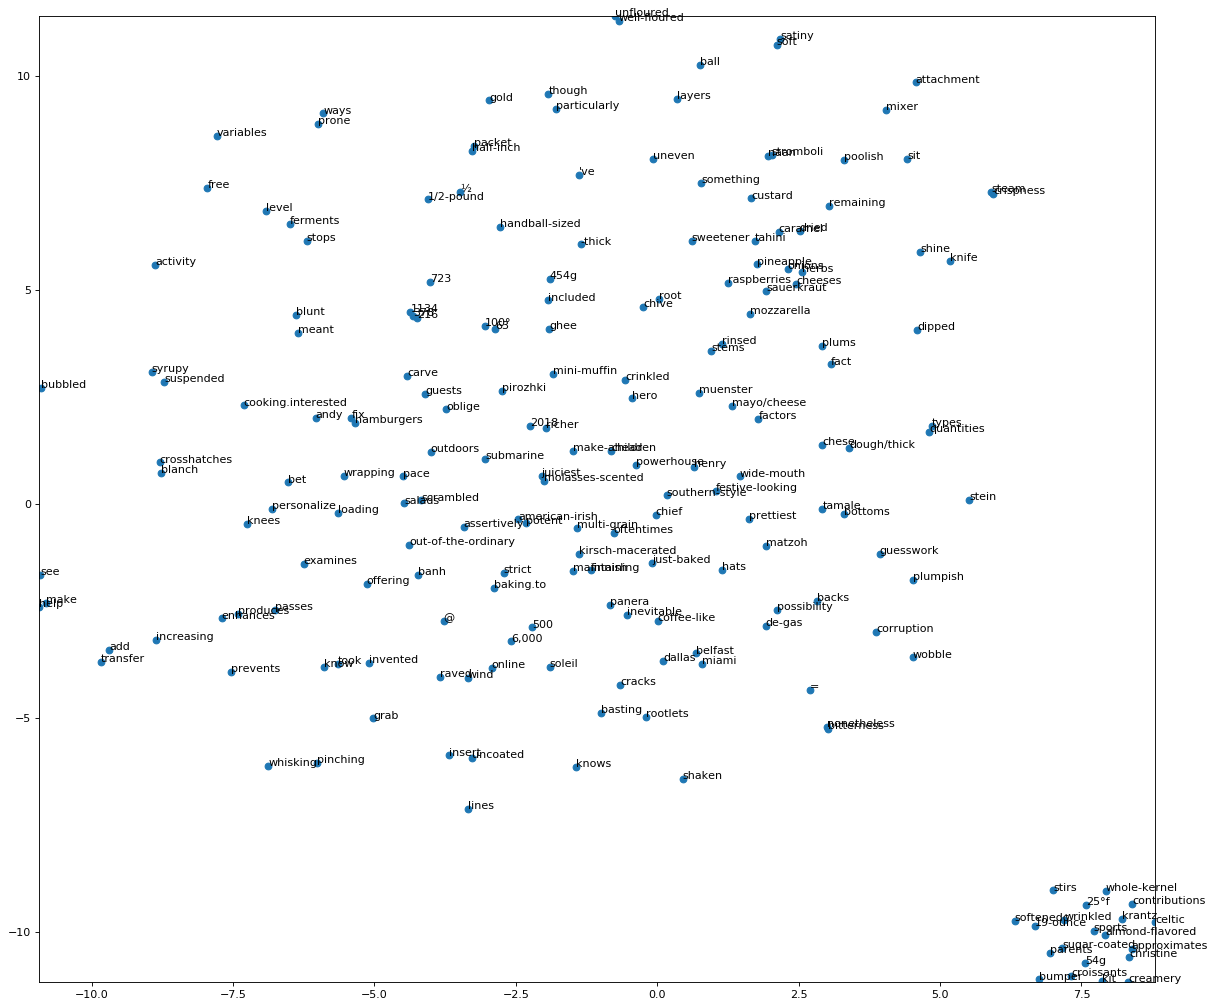

In [37]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x_coords, y_coords)

for label, x, y in zip(labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


Pretty interesting, seems to have learned this corpus a bit better